In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook

In [2]:
files_path = '/mlo-container-scratch/massemin/tweets_piped/'
files = [os.path.join(files_path, fn) for fn in sorted(os.listdir(files_path))]
dates = [f.split('.')[0].split('_')[-1] for f in files]

In [3]:
res = []
for f in tqdm_notebook(files) :
    df = pd.read_parquet(f, columns=['country_code', 'sentiment'])
    res.append(df.groupby('country_code').apply(lambda g : (len(g), (g['sentiment']==1).sum(), (g['sentiment']==0).sum())))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/430 [00:00<?, ?it/s]

Country Polarity and Epi

In [8]:
months = sorted(list(set([d[:-3] for d in dates])))[3:]

def mean_and_ci(sub) :

    x = sub.copy()
    x = np.array(sub)
    x = x[(x[:, 1] + x[:, 2]) > 0]
    # Compute global polarity (weighted average)
    counts = x.sum(axis=0)
    mean = (counts[1]-counts[2]) / (counts[1] + counts[2])


    # Compute confidence interval
    scores = (x[:, 1] - x[:, 2]) / (x[:, 1] + x[:, 2])
    ci = 2*scores.std() / np.sqrt(len(x))
    
    return mean, ci
    #return scores.mean(), ci

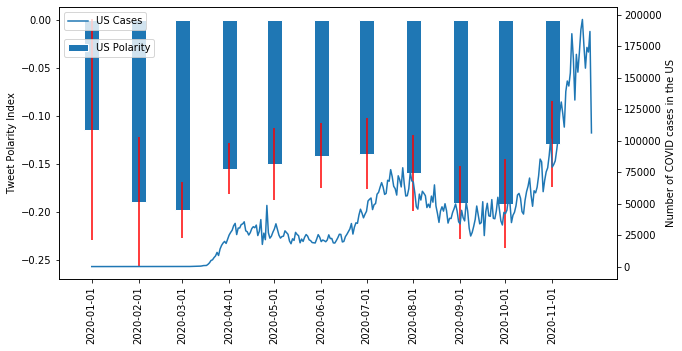

In [69]:
country = 'US'
months = sorted(list(set([d[:-3] for d in dates])))[3:]
epi_df = pd.read_csv('../Data/countries_data.csv')
epi_df = epi_df[epi_df.iso_code == 'USA']
country_dates = epi_df['date'].values

country_dates = dates[92:-7]
epi_dates = epi_df.date.values[1:]

to_legend=[]

# Compute polarity 
arr = np.array([r[country] if country in r.index else (0, 0, 0) for r in res])
splits = [arr[np.array([m in d for d in dates])] for m in months]
means, ci = zip(*[mean_and_ci(s) for s in splits])

#fig, axs = plt.subplots(2, sharex=True, sharey=True)
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

axs=[ax]
new_months = [np.argmax([m in d for d in country_dates]) for m in months]
bars =  axs[0].bar(x=np.arange(len(country_dates))[new_months][:-1], height=means[:-1], width=10, ecolor='red', yerr=ci[:-1], edgecolor='white', label=f'{country} Polarity')
to_legend.append(bars)
#axs[0].legend()     

#plt.plot(means)
  
axs[0].set_ylabel('Tweet Polarity Index')
axs[0].set_xticks(new_months[:-1])
axs[0].set_xticklabels(months[:-1], rotation=90)


#ax1=axs[1]
axs.append(ax.twinx())
epi_df = pd.read_csv('../Data/countries_data.csv')
epi_df = epi_df[epi_df.iso_code == 'USA']
lines = axs[1].plot(epi_df['case'].values[1:], label=f'{country} Cases')
to_legend.append(lines)
new_months = [np.argmax([m in d for d in epi_dates]) for m in months]
axs[1].set_xticks(new_months[:-1])
axs[1].set_xticklabels(epi_dates[new_months[:-1]], rotation=90)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Number of COVID cases in the US')


# Create a legend for the first line.
#first_legend = axs[0].legend()
#ax = axs[1].add_artist(first_legend)
#ax.legend()

axs[1].legend()
axs[0].legend(loc='upper left', bbox_to_anchor=(0, 0.9, 0, 0))

#plt.legend(to_legend[0], f'{country} Polarity')
#plt.legend(to_legend[1], f'{country} Cases')
#plt.legend((to_legend[0], to_legend[1]), [f'{country} Polarity', f'{country} Cases'])
#plt.tight_layout()
plt.savefig('polarity.png', dpi=600)

Topic trend

In [4]:
trends_path = '/mlo-container-scratch/massemin/twitter_covid_insights_v3/insights_All/new_trends.pkl'
trends = pkl.load(open(trends_path, 'rb'))[0]

topics_path = '/mlo-container-scratch/massemin/twitter_covid_insights_v3/insights_All/topics.pkl'
topics = pkl.load(open(topics_path, 'rb'))[0]

def month_polarity(topic_idx) :
    trend_dates = dates[92:-7]
    topic_idx=str(topic_idx)
    sub = np.array(list(zip(trends[str(topic_idx)][92:-7], 
                            trends[f'Pos-{topic_idx}'][92:-7], 
                            trends[f'Neg-{topic_idx}'][92:-7])))

    polarity = ((trends[f'Pos-{topic_idx}'] - trends[f'Neg-{topic_idx}'])) / trends[str(topic_idx)]
    splits = [sub[np.array([(m in d) for d in trend_dates])] for m in months[:-1]]
    means, ci = zip(*[mean_and_ci(s) for s in splits])
    return (means, ci)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


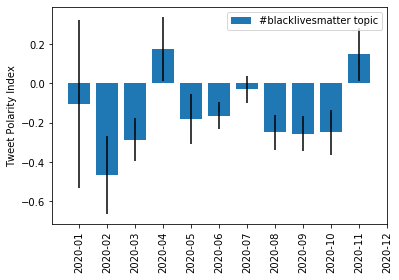

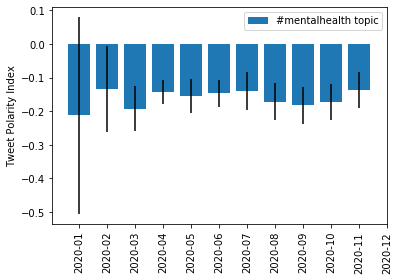

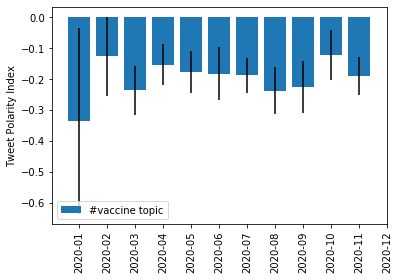

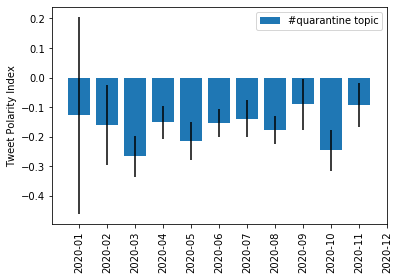

In [78]:
to_plot = [['354', '#blacklivesmatter', 'polarity_blm.png'],
          ['117', '#mentalhealth', 'polarity_mentalhealth.png'],
           ['64', '#vaccine', 'polarity_vaccine.png'],
           ['338', '#quarantine', 'polarity_quarantine.png']]


for t_id, t_hash, save_name in to_plot :
    means, ci = month_polarity(t_id)

    plt.bar(x=np.arange(len(months)-1), height=means, yerr=ci, ecolor='black', label=f'{t_hash} topic')
    plt.legend()    
    plt.ylabel('Tweet Polarity Index')
    plt.xticks(np.arange(len(months)), months, rotation=90)
    plt.savefig(save_name, dpi=600)
    plt.show()

Most polarized topics

In [6]:
def month_occs(topic_id) :
    matching_dates = np.array([np.array([m in d for d in dates]) for m in months[:-1]])
    nb_per_month = [trends[str(topic_id)][mask].sum() for mask in matching_dates]
    return nb_per_month

ranking = []
topic_ids = [c for c in trends if '-' not in c]
for t in topic_ids :
    ranking.append((t, month_polarity(t), month_occs(t)))

topn=5
min_nb_tweets = 1000
conf_thresh = 0.2


for e, m in enumerate(months[:-1]) :
    
    matching_dates = np.array([m in d for d in dates])
    
    robust_ranking = [r for r in ranking if (r[1][1][e] <=conf_thresh) and (r[2][e] >= min_nb_tweets)] 
    robust_ranking = sorted(robust_ranking, key=lambda r : -np.abs(r[1][0][e]))
    top_ids = [r[0] for r in robust_ranking][:topn]
    top_scores = [r[1][0][e] for r in robust_ranking][:topn]
    
    print(f'\n\n{m}')
    for top_score, top_id in zip(top_scores, top_ids) :
        print(f'\t{top_id} - {top_score:.3} : {topics[int(top_id)]}')

Heatmap

In [67]:
def only_epi_dates(trend) :
    return trend[91:-6]

# Load epi data
epi_df = pd.read_csv('../Data/countries_data.csv')
epi_features = ['date','case', 'death', 'transit', 'r_estim', 'stringency']
epi_df = epi_df[epi_df.iso_code == 'USA'][epi_features].reset_index(drop=True)

day_flux_path = '/mlo-container-scratch/massemin/twitter_covid_insights_v3/insights_All/day_flux.pkl'
day_flux = pkl.load(open(day_flux_path, 'rb'))
epi_df['day_flux'] = only_epi_dates(day_flux)


features_1 = epi_features + ['day_flux']
features_1.remove('date')

for tid in ['117', '338', '64'] :
    epi_df[f'{tid}_nb_tweets'] = only_epi_dates(trends[tid])
    epi_df[f'{tid}_rel_nb_tweets'] = only_epi_dates(trends[tid] / day_flux)
    epi_df[f'{tid}_pol'] = only_epi_dates((trends[f'Pos-{tid}'] - trends[f'Neg-{tid}']) / (trends[f'Pos-{tid}'] + trends[f'Neg-{tid}']))
    
features_2 = sorted(list(set(epi_df.columns) - set(features_1)))
features_2.remove('date')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [71]:
final_heatmap = epi_df.corr().loc[features_1, features_2]

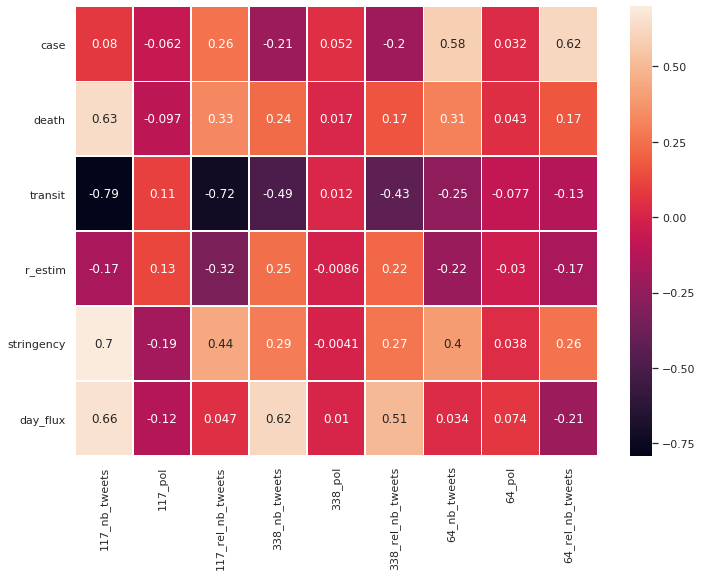

In [82]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.heatmap(final_heatmap, annot=True, linewidths=.5)
b, t = plt.ylim()
b += 0.5
t -= 0.5 
plt.ylim(b, t) 

plt.yticks(rotation=0)
plt.show() 

Highest/Lowest correlations

In [58]:
def pol_from_id(tid) :
    return only_epi_dates((trends[f'Pos-{tid}'] - trends[f'Neg-{tid}']) / (trends[f'Pos-{tid}'] + trends[f'Neg-{tid}']))

topic_ids = [c for c in trends if '-' not in c] 
pol_corr_df = pd.DataFrame(dict([(str(t), pol_from_id(t)) for t in topic_ids]))

for f in features_1 :
    pol_corr_df[f] = epi_df[f]

all_pol_corr = pol_corr_df.corr().loc[topic_ids][features_1]
all_pol_corr

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


,case,death,transit,r_estim,stringency,day_flux
0,-0.009419,-0.034418,-0.037132,-0.081943,0.019575,-0.030492
1,0.058301,0.010210,-0.058850,-0.063850,0.066443,-0.058559
2,0.015628,0.051275,0.020001,-0.045525,-0.042176,0.061160
3,0.029779,0.010437,0.017627,0.075807,-0.037629,-0.006596
4,-0.023598,0.006886,0.018450,-0.101811,-0.024835,-0.024683
...,...,...,...,...,...,...
864,-0.074724,0.012451,-0.106257,-0.019858,0.122747,0.085423
865,-0.026678,-0.160072,-0.140658,0.167912,-0.056190,-0.173895
866,-0.056933,0.055997,-0.116739,0.085390,0.054849,0.068645
867,0.130104,0.017062,-0.063782,-0.145962,0.051055,-0.139384


In [66]:
nb_corrs = 10

# Find Strongest correlations and their associated topics
corr_ids = np.array(list(zip([e for x in topic_ids for e in [x]*len(features_1)], features_1*len(all_pol_corr))))
argsrt = np.argsort(-all_pol_corr.values.flatten())

strong_arg = np.concatenate((argsrt[:nb_corrs], argsrt[-nb_corrs:])) 
strong_corrs = all_pol_corr.values.flatten()[strong_arg]
strong_corrs_idxs = corr_ids[strong_arg]

results = list(zip(strong_corrs, corr_ids[strong_arg]))
for r in results :
    print(f'\n{r[0]:.3} ({r[1][0]}-{r[1][1]}) - {topics[int(r[1][0])]}')


0.548 (831-transit) - ['#postponetn10thexam' '#wearejust15' '#savethenextgentn'
 '#postpone10thexam' '#justicefortn10thexam' '#plshelpstalin']

0.542 (792-day_flux) - ['#ய' '#yarlosai' '#yarlosai_news' '#voice_of_jaffna' '#news_1st_headline'
 '#today_trending']

0.507 (801-r_estim) - ['#postpone_aiims11june' '#postpone_aiims_11june' '#postponeaiimspg'
 '#postpone_midyear_exams' '#postpone_aiims_11jun' '#savedoctors11june']

0.499 (319-death) - ['#yg_respect_blackpink' '#แบรนด' '#brandsmorningcall'
 '#lisaforhuaguoqingru' '#yedam' '#nct127_1m_seller_축하해'
 '#makefriends_igot7']

0.417 (835-r_estim) - ['#rollyph' '#ulyssesph' '#cagayanneedshelp' '#rescueph'
 '#isabelaneedshelp' '#goni' '#quintaph']

0.397 (868-transit) - ['#حياه_اولادنا_اهم_من_3ث' '#بالتعقيم_الاطباء_ماتو_اجلو3ث'
 '#رئاسه_الوزرا_العدل_تاجيل_3ث' '#نزول3ث_كارثه_ياريس_الحقنا'
 '#متغامروش_بطلاب_3ث_ياريس' '#تاجيل_لدفعه_3ث_ياريس']

0.358 (652-transit) - ['#desescalada' '#bcnlegends' '#urbangraffitisbcn' '#blegends' '#acabose'
 